In [1]:
!pip install -q keras-tuner kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
import os
import random
import itertools
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import keras_tuner as kt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import datetime
import pandas as pd
from pathlib import Path
import shutil
import logging
import json
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomZoom, RandomFlip, RandomRotation, RandomTranslation, RandomContrast, RandomBrightness

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set Kaggle Config Directory
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas"

In [ ]:
# Change Directory
%cd /content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset

In [ ]:
# Download dataset from kaggle
!kaggle datasets download samuelcortinhas/muffin-vs-chihuahua-image-classification

In [ ]:
# unzip
!unzip -q /content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/muffin-vs-chihuahua-image-classification.zip

In [ ]:
# Remove
!rm /content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/muffin-vs-chihuahua-image-classification.zip

In [4]:
train_path = "/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/train"
test_path = "/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/test"

In [5]:
def create_data_frame(directory, categories):

    df = pd.DataFrame(columns=['filepath', 'label'])
    for label, folder in enumerate(categories):
        folder_path = os.path.join(directory, folder)
        image_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith(('png', 'jpg', 'jpeg'))]
        df = pd.concat([df, pd.DataFrame({'filepath': image_files, 'label': str(label)})])
    return df

# Specify categories present in both train and test directories
categories = ['muffin', 'chihuahua']

# Create DataFrames for training/validation and test datasets
train_valid_df = create_data_frame(train_path, categories)
test_df = create_data_frame(test_path, categories)


In [6]:
train_valid_df.head()

filepath label
0  /content/drive/MyDrive/ML_Project_Muffins_Chih...     0
1  /content/drive/MyDrive/ML_Project_Muffins_Chih...     0
2  /content/drive/MyDrive/ML_Project_Muffins_Chih...     0
3  /content/drive/MyDrive/ML_Project_Muffins_Chih...     0
4  /content/drive/MyDrive/ML_Project_Muffins_Chih...     0

In [7]:
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state = 50)

In [7]:
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state = 0)

In [8]:
img_size = (224, 224)
batch_size = 64


datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode='binary',
    color_mode='rgb',
)


valid_data = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode='binary',
    color_mode='rgb',
)


test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 3549 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.


In [9]:
def display_sample_images(data_generator, num_images=10, title_labels=['Muffin', 'Chihuahua']):
    # Fetch one batch of data
    sample_images, sample_labels = next(iter(data_generator))

    # Create a figure with subplots in a grid
    plt.figure(figsize=(20, 7))
    for i in range(min(num_images, len(sample_images))):
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(sample_images[i])
        plt.axis('off')
        # Set title of each subplot to show corresponding label
        label_index = int(sample_labels[i])
        if label_index < len(title_labels):
            plt.title(title_labels[label_index])

    # Show the complete figure with images
    plt.tight_layout()
    plt.show()


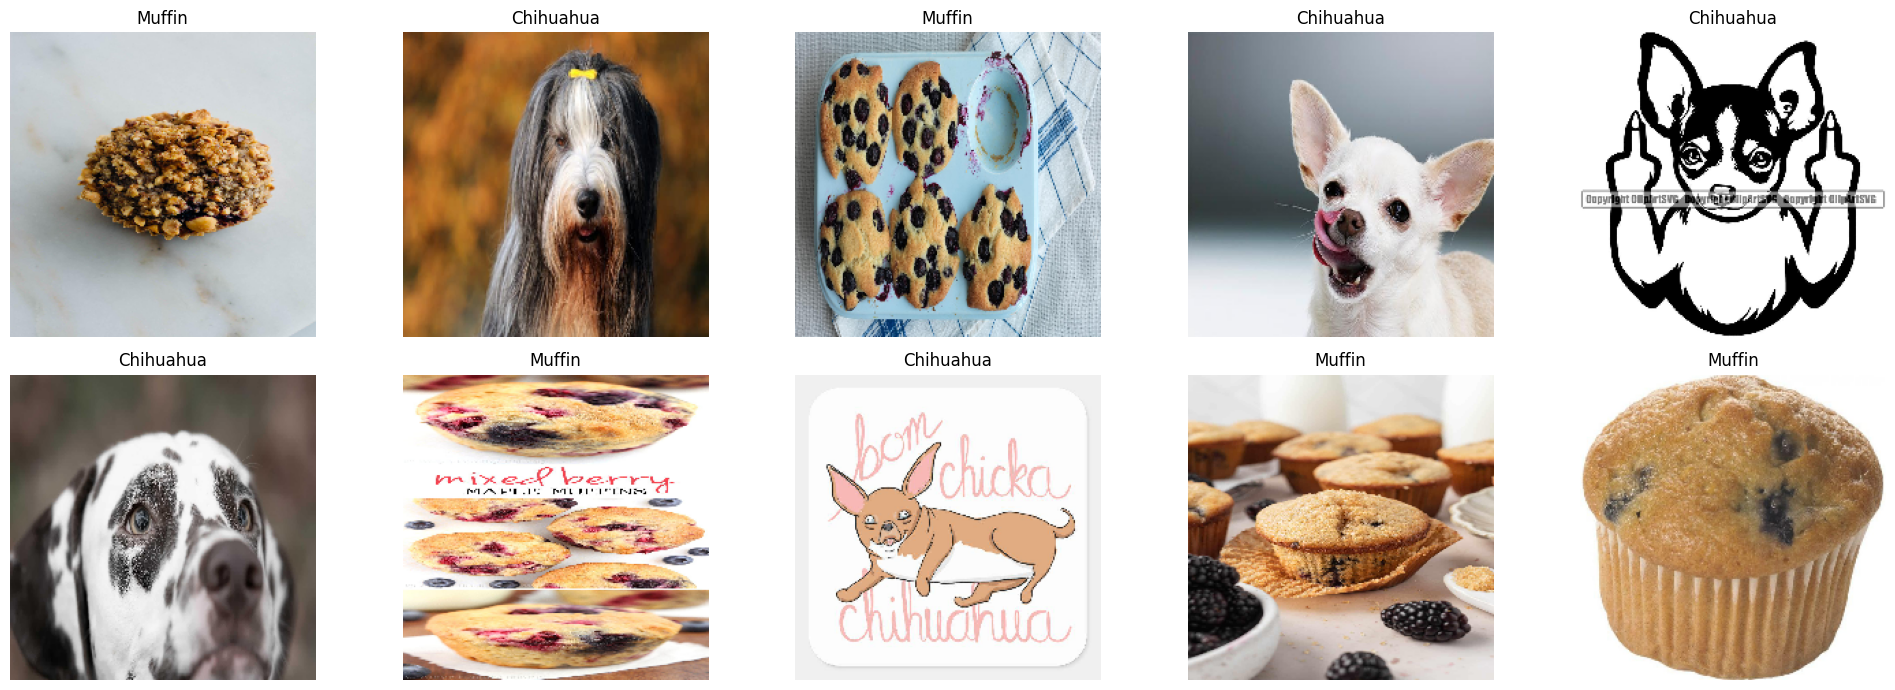

In [10]:
display_sample_images(train_data)

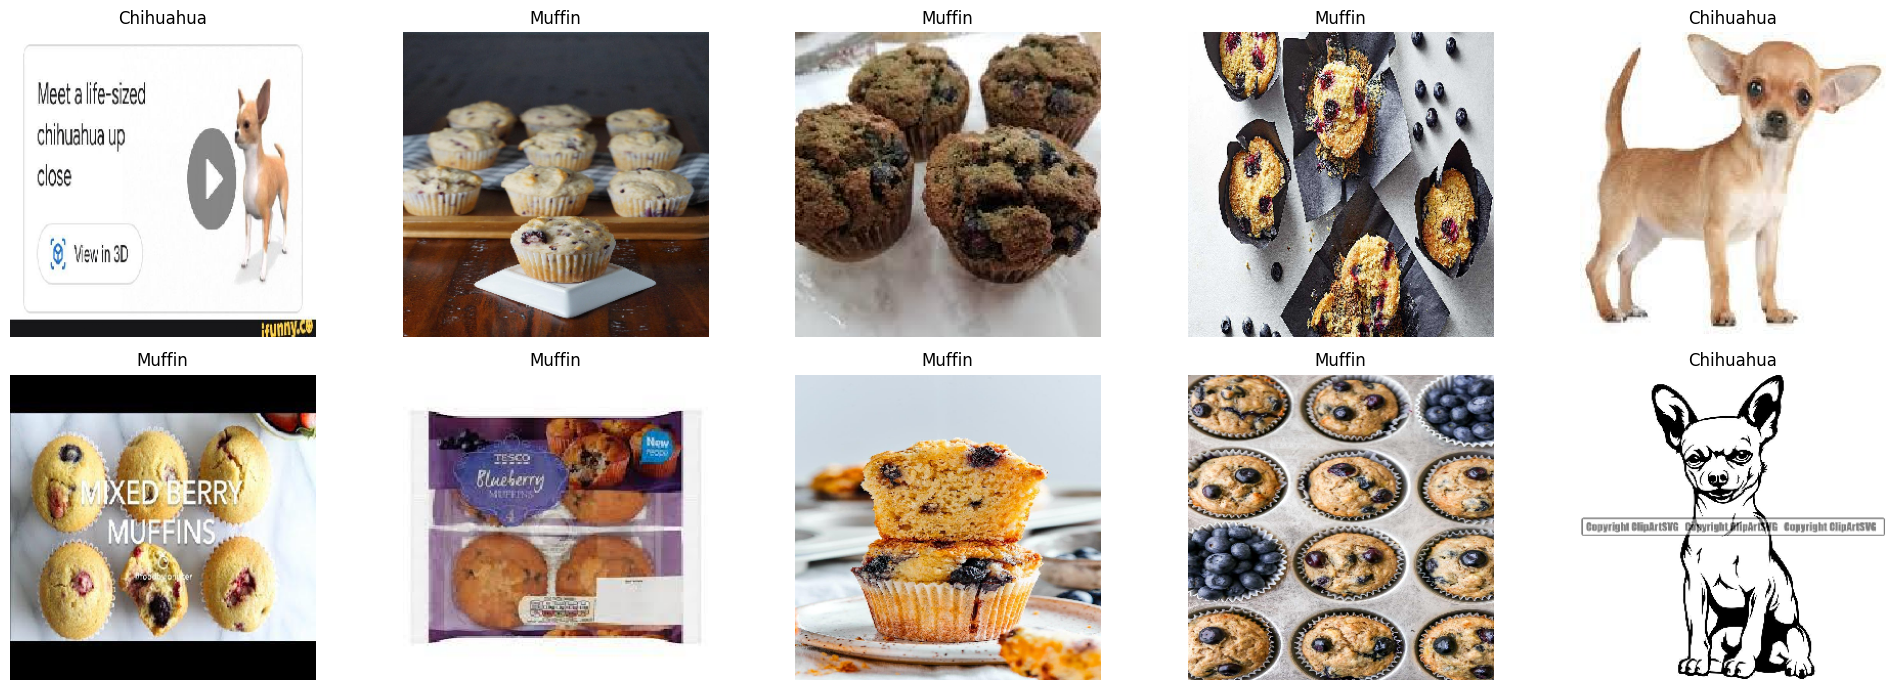

In [ ]:
display_sample_images(valid_data)

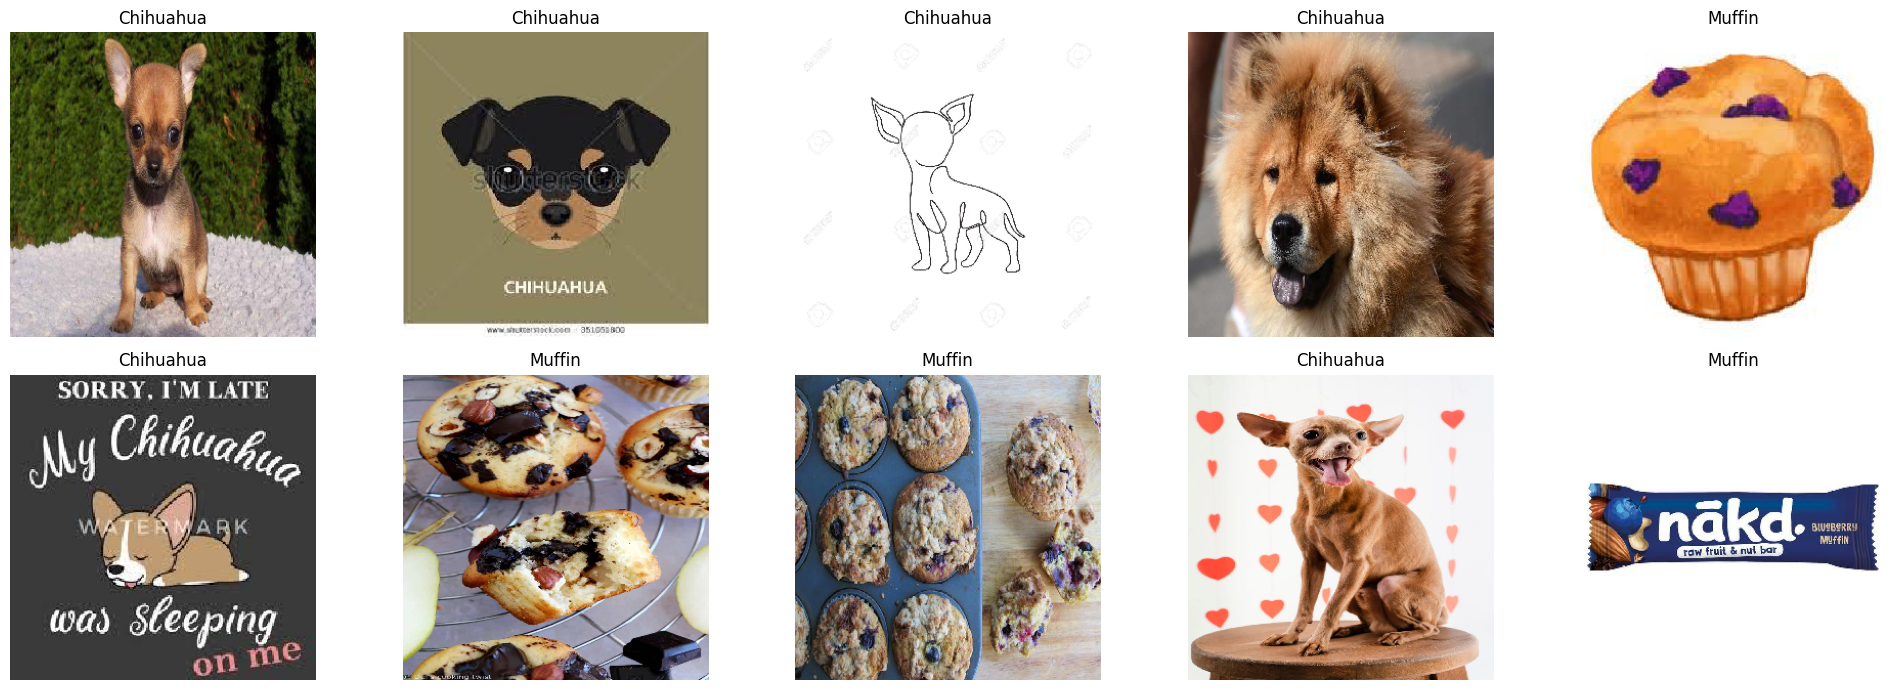

In [ ]:
display_sample_images(test_data)

# model 1

In [11]:
# Function to plot training and validation accuracy and loss
def plot_history(history, metric):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history[metric], 'bo-', label=f'Train {metric.title()}')
    plt.plot(history.history[f'val_{metric}'], 'ro-', label=f'Validation {metric.title()}')
    plt.title(f'Model {metric.title()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.show()

In [13]:
# Define the architecture
model = Sequential(name='Model_1')

# 4 Convolutional blocks
model.add(Conv2D(32, (3, 3), activation='tanh', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='tanh', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='tanh', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0   

Epoch 1/30
55/55 [==============================] - 68s 1s/step - loss: 0.6089 - accuracy: 0.6603 - val_loss: 0.4681 - val_accuracy: 0.7821
Epoch 2/30
55/55 [==============================] - 56s 1s/step - loss: 0.4301 - accuracy: 0.8052 - val_loss: 0.4313 - val_accuracy: 0.8021
Epoch 3/30
55/55 [==============================] - 59s 1s/step - loss: 0.3743 - accuracy: 0.8313 - val_loss: 0.4933 - val_accuracy: 0.7752
Epoch 4/30
55/55 [==============================] - 56s 1s/step - loss: 0.3432 - accuracy: 0.8539 - val_loss: 0.3515 - val_accuracy: 0.8472
Epoch 5/30
55/55 [==============================] - 47s 855ms/step - loss: 0.3129 - accuracy: 0.8694 - val_loss: 0.3003 - val_accuracy: 0.8733
Epoch 6/30
55/55 [==============================] - 56s 1s/step - loss: 0.2954 - accuracy: 0.8786 - val_loss: 0.2944 - val_accuracy: 0.8837
Epoch 7/30
55/55 [==============================] - 56s 1s/step - loss: 0.2973 - accuracy: 0.8737 - val_loss: 0.2904 - val_accuracy: 0.8776
Epoch 8/30
55/55 

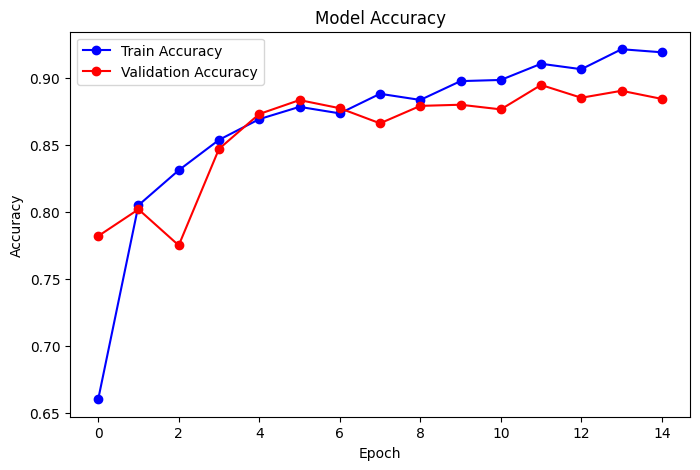

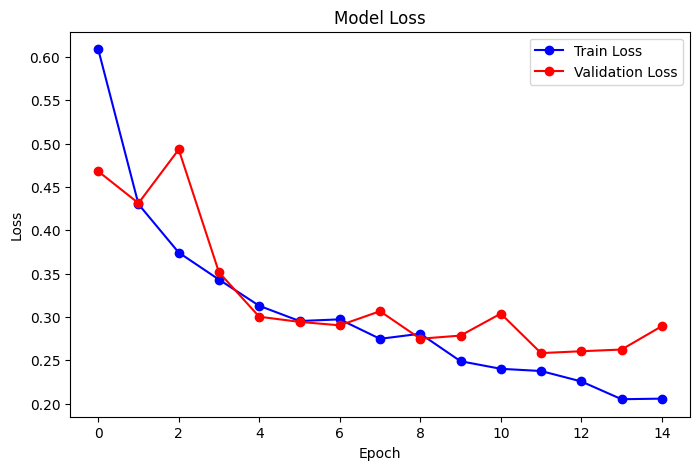

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.n // train_data.batch_size,
    epochs=30,
    validation_data=valid_data,
    validation_steps=valid_data.n // valid_data.batch_size,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Plotting the accuracy
plot_history(history, 'accuracy')

# Plotting the loss
plot_history(history, 'loss')



# model2

In [ ]:
# Define the architecture
model2 = Sequential(name='Model_2')

# 4 Convolutional blocks
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                     

Epoch 1/20
55/55 [==============================] - 83s 1s/step - loss: 0.6081 - accuracy: 0.6628 - val_loss: 0.4715 - val_accuracy: 0.7665
Epoch 2/20
55/55 [==============================] - 50s 899ms/step - loss: 0.4526 - accuracy: 0.7894 - val_loss: 0.3986 - val_accuracy: 0.8168
Epoch 3/20
55/55 [==============================] - 59s 1s/step - loss: 0.3778 - accuracy: 0.8333 - val_loss: 0.3568 - val_accuracy: 0.8385
Epoch 4/20
55/55 [==============================] - 51s 924ms/step - loss: 0.3378 - accuracy: 0.8525 - val_loss: 0.3175 - val_accuracy: 0.8672
Epoch 5/20
55/55 [==============================] - 50s 909ms/step - loss: 0.3108 - accuracy: 0.8712 - val_loss: 0.2971 - val_accuracy: 0.8681
Epoch 6/20
55/55 [==============================] - 60s 1s/step - loss: 0.2699 - accuracy: 0.8841 - val_loss: 0.2813 - val_accuracy: 0.8785
Epoch 7/20
55/55 [==============================] - 59s 1s/step - loss: 0.2431 - accuracy: 0.9042 - val_loss: 0.2912 - val_accuracy: 0.8845
Epoch 8/20


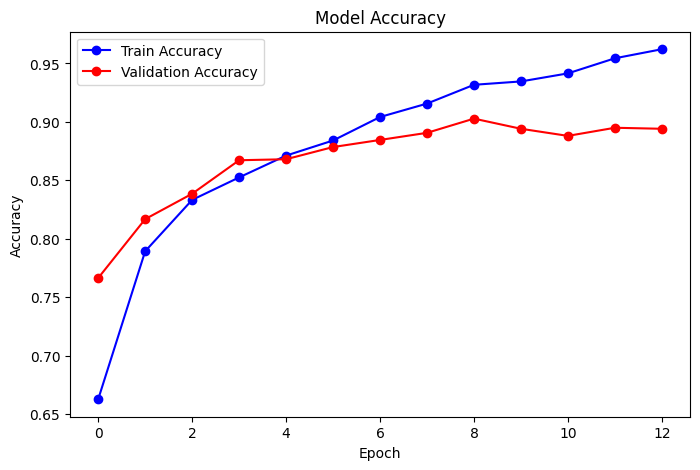

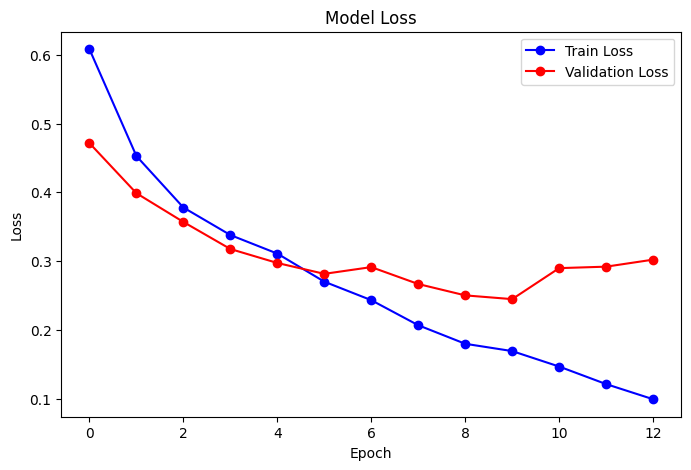

In [ ]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

# Train the model
history = model2.fit(
    train_data,
    steps_per_epoch=train_data.n // train_data.batch_size,
    epochs=20,
    validation_data=valid_data,
    validation_steps=valid_data.n // valid_data.batch_size,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = model2.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Plotting the accuracy
plot_history(history, 'accuracy')

# Plotting the loss
plot_history(history, 'loss')


# model3

In [14]:
def build_model3():
    model3 = Sequential(name='Model_3')

    # 4 Convolutional blocks
    model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model3.add(Dropout(0.2))

    model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model3.add(Dropout(0.2))

    model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model3.add(Dropout(0.2))

    model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model3.add(Dropout(0.2))

    # Fully connected layers
    model3.add(Flatten())
    model3.add(Dense(128, activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model3

In [15]:
# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

tensorboard = [keras.callbacks.TensorBoard(log_dir="/content/drive/MyDrive/new_ml/results",)]

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 64)      36928     
                                                           

In [17]:
# Initialize the StratifiedKFold object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Prepare the data for cross-validation
filepaths = train_valid_df['filepath'].values
labels = train_valid_df['label'].values

# Arrays for storing metrics
val_losses = []
val_accuracies = []
histories = []

# Perform cross-validation
for train_index, valid_index in kfold.split(filepaths, labels):
    # Split the data into training and validation sets
    train_files, valid_files = filepaths[train_index], filepaths[valid_index]
    train_labels, valid_labels = labels[train_index], labels[valid_index]

    datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2)

    # Create data generators for the current fold
    train_data = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filepath': train_files, 'label': train_labels}),
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary',
        color_mode='rgb'
    )

    valid_data = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filepath': valid_files, 'label': valid_labels}),
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary',
        color_mode='rgb',
        shuffle=False
    )


    model3 = build_model3()

    # Train the model on the current fold
    history = model3.fit(
        train_data,
        steps_per_epoch=train_data.n // train_data.batch_size,
        epochs=20,
        validation_data=valid_data,
        validation_steps=valid_data.n // valid_data.batch_size,
        callbacks=[callbacks, keras.callbacks.TensorBoard(log_dir='/tmp/tensorboard')]
    )

    histories.append(history)

    # Evaluate the model on the validation set
    valid_loss, valid_accuracy = model3.evaluate(valid_data)
    val_losses.append(valid_loss)
    val_accuracies.append(valid_accuracy)

Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
Epoch 1/20
59/59 [==============================] - 104s 2s/step - loss: 0.7142 - accuracy: 0.5505 - val_loss: 0.5537 - val_accuracy: 0.7333
Epoch 2/20
59/59 [==============================] - 98s 2s/step - loss: 0.6102 - accuracy: 0.6462 - val_loss: 0.4976 - val_accuracy: 0.7835
Epoch 3/20
59/59 [==============================] - 101s 2s/step - loss: 0.4860 - accuracy: 0.7770 - val_loss: 0.4297 - val_accuracy: 0.8292
Epoch 4/20
59/59 [==============================] - 105s 2s/step - loss: 0.4543 - accuracy: 0.8111 - val_loss: 0.3739 - val_accuracy: 0.8438
Epoch 5/20
59/59 [==============================] - 106s 2s/step - loss: 0.4265 - accuracy: 0.8224 - val_loss: 0.3946 - val_accuracy: 0.8371
Epoch 6/20
59/59 [==============================] - 104s 2s/step - loss: 0.3844 - accuracy: 0.8444 - val_loss: 0.4447 - val_accuracy: 0.7913
Epoch 7/20
59/59 [================

In [ ]:
model3.summary()

In [18]:
# Calculate the average validation loss and accuracy
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f'Average Validation Loss: {avg_val_loss}')
print(f'Average Validation Accuracy: {avg_val_accuracy}')

Average Validation Loss: 0.23253294229507446
Average Validation Accuracy: 0.9121081113815308


In [21]:
# Assuming test_data is already prepared and available similar to train_data
test_loss, test_accuracy = model3.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

19/19 [==============================] - 931s 52s/step - loss: 0.2144 - accuracy: 0.9223
Test Loss: 0.21440085768699646
Test Accuracy: 0.9222972989082336


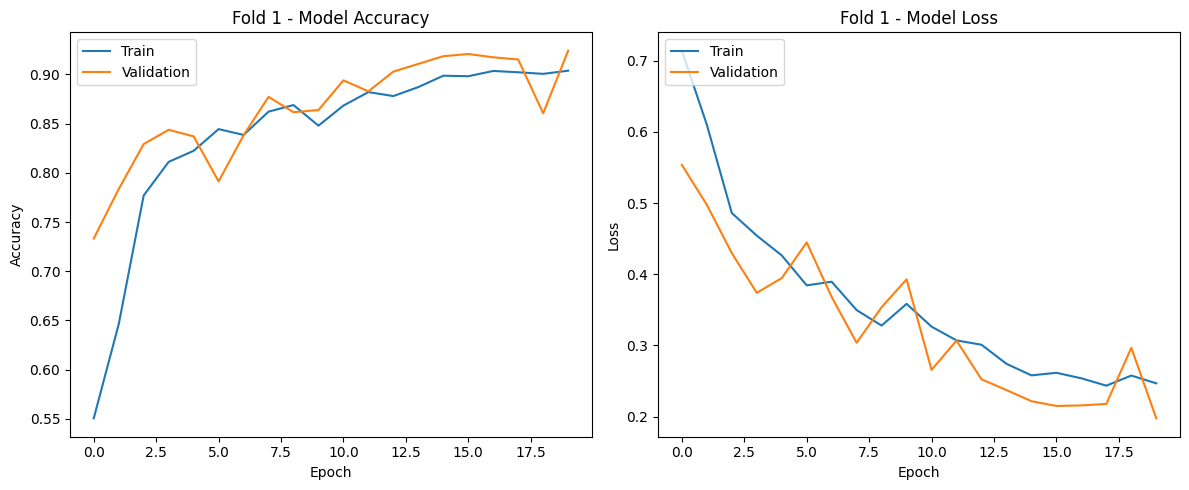

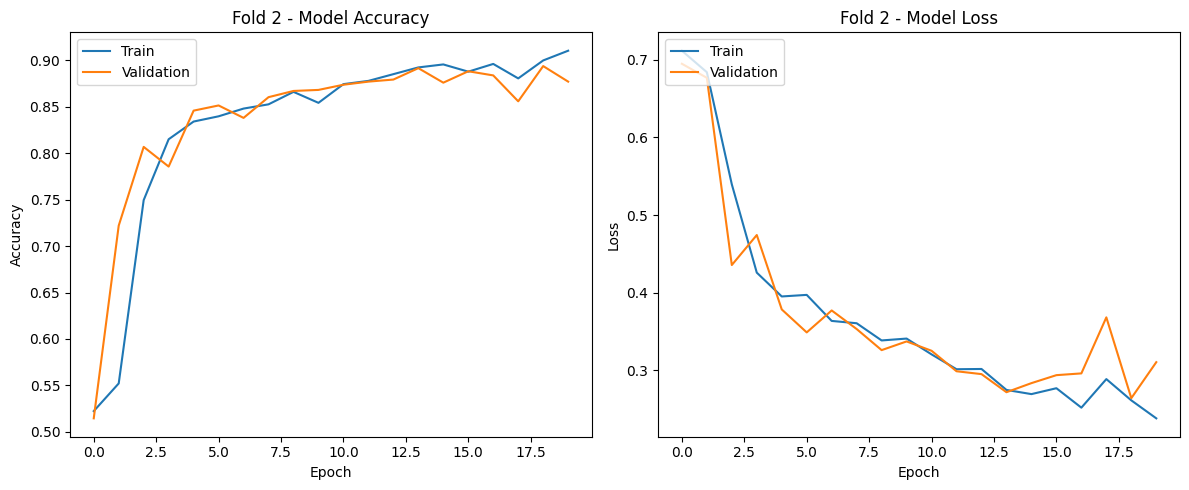

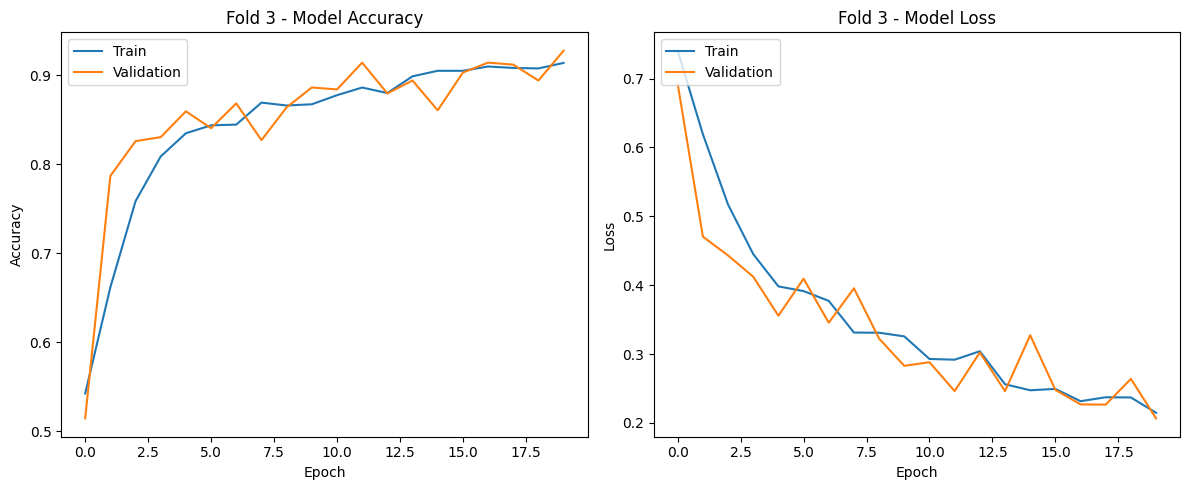

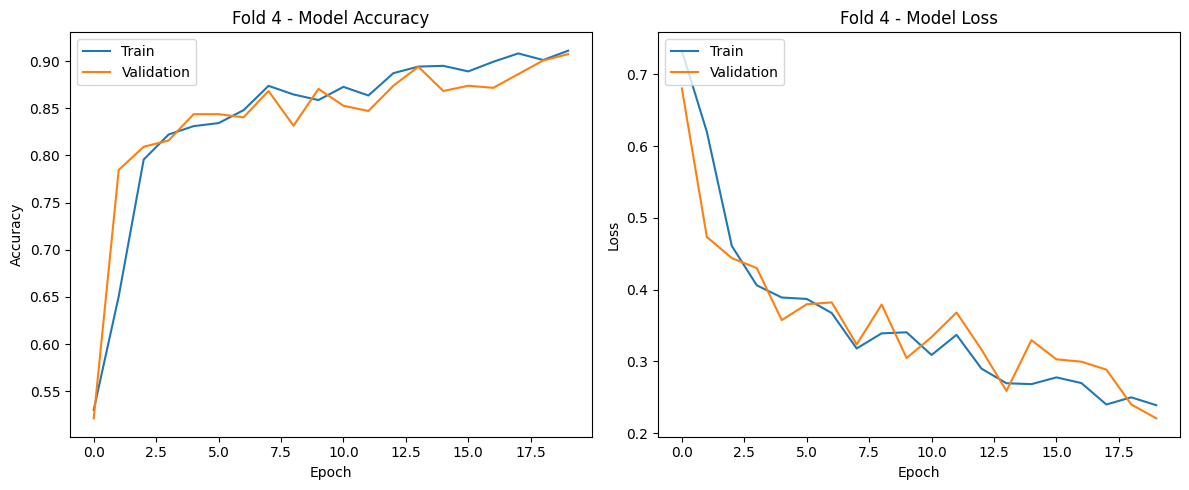

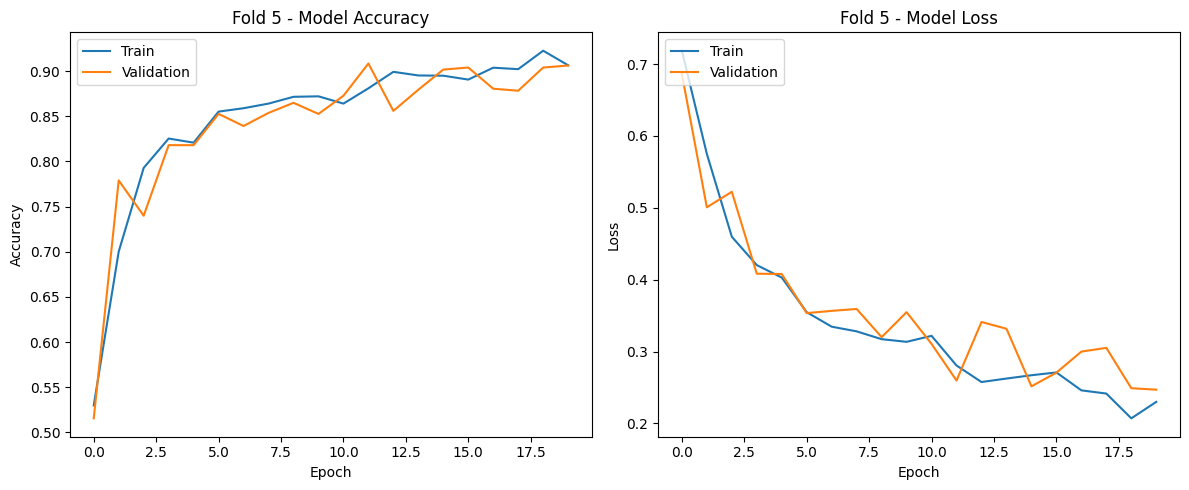

In [22]:
def plot_metrics(histories, metric_names=['accuracy', 'loss']):
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 5))  # Slightly adjusted for better aspect ratio

        for j, metric in enumerate(metric_names):
            plt.subplot(1, 2, j+1)  # Indexing at 1 for subplot which is 1-based
            plt.plot(history.history[metric], label='Train')
            plt.plot(history.history['val_' + metric], label='Validation')
            plt.title(f'Fold {i + 1} - Model {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend(loc='upper left')

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

plot_metrics(histories)

# hyper parameter model 3

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from keras.optimizers import Adam
import keras_tuner as kt

def build_hypermodel(hp):
    # Define hyperparameter search space
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(hp.Float("rotation", min_value=0.01, max_value=0.3, step=0.01)),
        RandomZoom(hp.Float("zoom", min_value=0.01, max_value=0.3, step=0.01))
    ])

    model = Sequential(name='Model4')
    model.add(data_augmentation)

    # Define convolution blocks with dynamic hyperparameters
    for i, num_filters in enumerate([32, 64, 128, 256]):
        num_filter = hp.Choice(f'num_filter_b{i+1}', values=[num_filters, num_filters * 2])
        model.add(Conv2D(num_filter, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(num_filter, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
        model.add(Dropout(hp.Float(f"dropout_block_b{i+1}", min_value=0.05, max_value=0.15, step=0.01)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(hp.Choice('num_fc', values=[128, 256, 512]), activation='relu'))
    model.add(Dropout(hp.Float("dropout_fc", min_value=0.2, max_value=0.4, step=0.05)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])),
        metrics=['accuracy']
    )

    return model

# Initialize the tuner
tuner = kt.BayesianOptimization(
    hypermodel=build_hypermodel,
    objective="val_accuracy",
    max_trials=20,
    directory='tuner_results',
    project_name='tune_model_hyperparameters'
)

# Define callbacks
early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

# Execute the hyperparameter search
tuner.search(
    x=train_data,
    epochs=30,
    batch_size=64,
    validation_data=valid_data,
    callbacks=early_stop
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


Trial 20 Complete [00h 18m 50s]
val_accuracy: 0.5412262082099915

Best val_accuracy So Far: 0.9217758774757385
Total elapsed time: 12h 01m 36s
{'rotation': 0.17, 'zoom': 0.11, 'num_filter_b1': 32, 'dropout_block_b1': 0.13, 'num_filter_b2': 128, 'dropout_block_b2': 0.13, 'num_filter_b3': 128, 'dropout_block_b3': 0.07, 'num_filter_b4': 256, 'dropout_block_b4': 0.08, 'num_fc': 256, 'dropout_fc': 0.2, 'lr': 0.001}


# model4

In [23]:
data_aug = Sequential([
    RandomRotation(0.17),
    RandomZoom(0.11),
    RandomFlip("horizontal")
])

In [24]:
def build_model4():
    model4 = Sequential(name='Model_4')

    model4.add(data_aug)

    # 4 Convolutional blocks
    model4.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model4.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model4.add(Dropout(0.13))

    model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model4.add(Dropout(0.13))

    model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model4.add(Dropout(0.07))

    model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model4.add(Dropout(0.08))

    # Fully connected layers
    model4.add(Flatten())
    model4.add(Dense(256, activation='relu'))
    model4.add(Dropout(0.2))
    model4.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model4

In [25]:
# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

tensorboard = [keras.callbacks.TensorBoard(log_dir="/content/drive/MyDrive/new_ml/results",)]

In [26]:
# Initialize the StratifiedKFold object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Prepare the data for cross-validation
filepaths = train_valid_df['filepath'].values
labels = train_valid_df['label'].values

# Arrays for storing metrics
val_losses = []
val_accuracies = []
histories = []

# Perform cross-validation
for train_index, valid_index in kfold.split(filepaths, labels):
    # Split the data into training and validation sets
    train_files, valid_files = filepaths[train_index], filepaths[valid_index]
    train_labels, valid_labels = labels[train_index], labels[valid_index]

    datagen = ImageDataGenerator(rescale=1./255)

    # Create data generators for the current fold
    train_data = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filepath': train_files, 'label': train_labels}),
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary',
        color_mode='rgb'
    )

    valid_data = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filepath': valid_files, 'label': valid_labels}),
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary',
        color_mode='rgb',
        shuffle=False
    )


    model4 = build_model4()

    # Train the model on the current fold
    history = model4.fit(
        train_data,
        steps_per_epoch=train_data.n // train_data.batch_size,
        epochs=30,
        validation_data=valid_data,
        validation_steps=valid_data.n // valid_data.batch_size,
        callbacks=[callbacks, keras.callbacks.TensorBoard(log_dir='/tmp/tensorboard')]
    )

    histories.append(history)

    # Evaluate the model on the validation set
    valid_loss, valid_accuracy = model4.evaluate(valid_data)
    val_losses.append(valid_loss)
    val_accuracies.append(valid_accuracy)

Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
Epoch 1/30
59/59 [==============================] - 62s 845ms/step - loss: 0.7232 - accuracy: 0.5193 - val_loss: 0.6927 - val_accuracy: 0.5145
Epoch 2/30
59/59 [==============================] - 46s 774ms/step - loss: 0.6843 - accuracy: 0.5481 - val_loss: 0.6030 - val_accuracy: 0.7076
Epoch 3/30
59/59 [==============================] - 49s 841ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4243 - val_accuracy: 0.8225
Epoch 4/30
59/59 [==============================] - 50s 850ms/step - loss: 0.4391 - accuracy: 0.8100 - val_loss: 0.3602 - val_accuracy: 0.8627
Epoch 5/30
59/59 [==============================] - 49s 830ms/step - loss: 0.4117 - accuracy: 0.8235 - val_loss: 0.3634 - val_accuracy: 0.8426
Epoch 6/30
59/59 [==============================] - 46s 786ms/step - loss: 0.3925 - accuracy: 0.8356 - val_loss: 0.3463 - val_accuracy: 0.8359
Epoch 7/30
59/59 [===

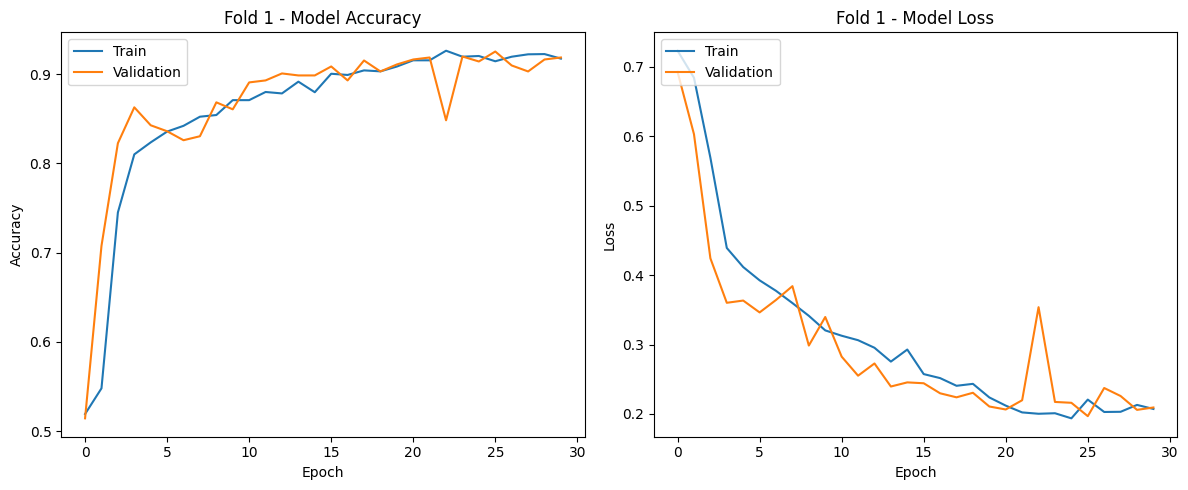

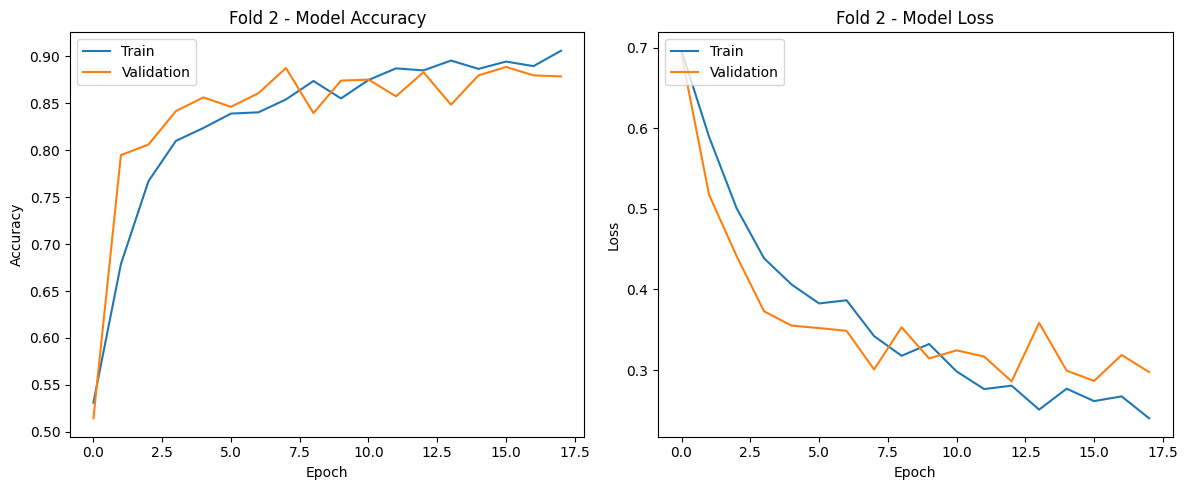

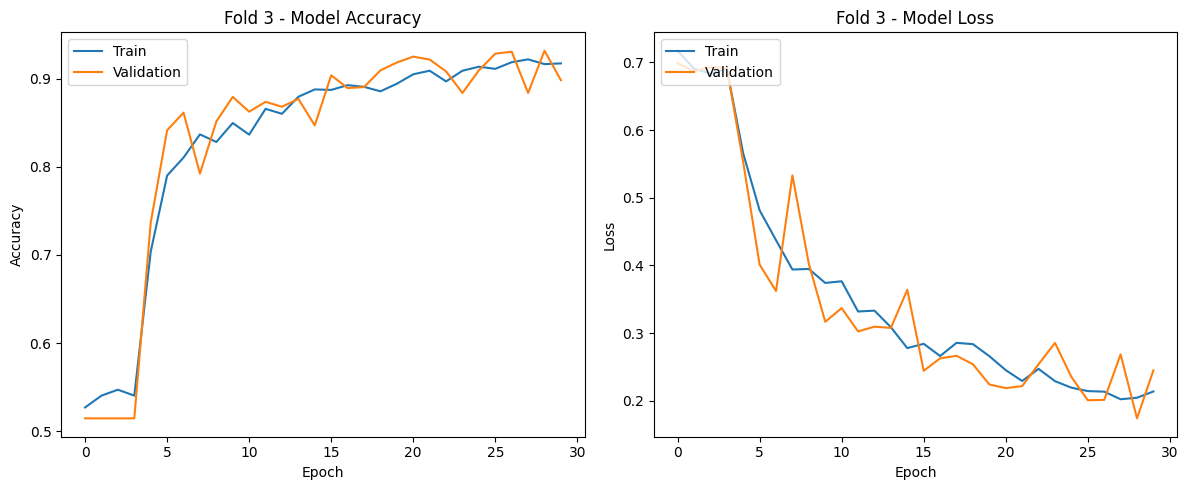

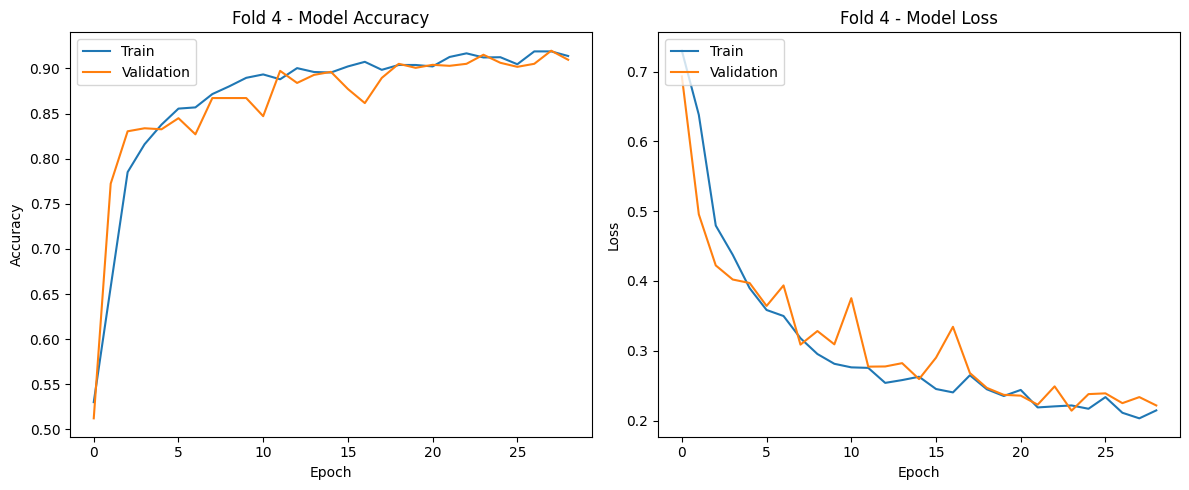

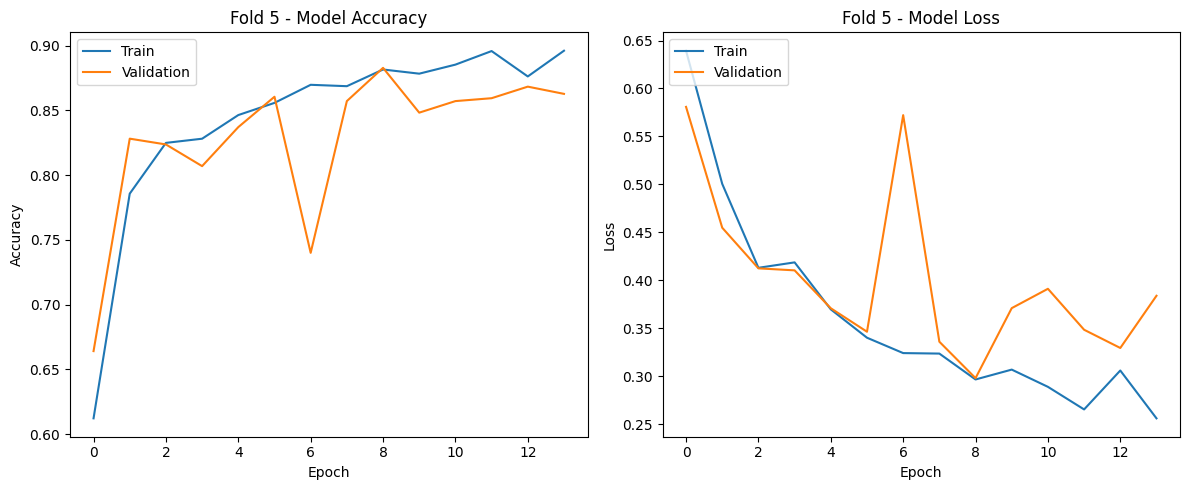

In [27]:
def plot_metrics(histories, metric_names=['accuracy', 'loss']):
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 5))  # Slightly adjusted for better aspect ratio

        for j, metric in enumerate(metric_names):
            plt.subplot(1, 2, j+1)  # Indexing at 1 for subplot which is 1-based
            plt.plot(history.history[metric], label='Train')
            plt.plot(history.history['val_' + metric], label='Validation')
            plt.title(f'Fold {i + 1} - Model {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend(loc='upper left')

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

plot_metrics(histories)

In [28]:
model4.summary()

Model: "Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, None, None, None   0         
                             )                                   
                                                                 
 conv2d_52 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 conv2d_53 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, None, None, 32)    0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, None, None, 32)    0         
                                                                 
 conv2d_54 (Conv2D)          (None, None, None, 128)   3699

In [28]:
# Calculate the average validation loss and accuracy
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f'Average Validation Loss: {avg_val_loss}')
print(f'Average Validation Accuracy: {avg_val_accuracy}')

Average Validation Loss: 0.270174640417099
Average Validation Accuracy: 0.8939341068267822


In [29]:
# Assuming test_data is already prepared and available similar to train_data
test_loss, test_accuracy = model4.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

19/19 [==============================] - 12s 629ms/step - loss: 0.3492 - accuracy: 0.8682
Test Loss: 0.3492129445075989
Test Accuracy: 0.8682432174682617


In [30]:
import numpy as np
from sklearn.metrics import accuracy_score

# Predicting labels for test data
predicted_probabilities = model4.predict(test_data)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# True labels need to be extracted if not directly available
true_labels = test_data.classes

# Calculating zero-one loss
zero_one_loss = np.sum(predicted_labels.flatten() != true_labels) / len(true_labels)
print(f'Zero-One Loss: {zero_one_loss}')


19/19 [==============================] - 11s 547ms/step
Zero-One Loss: 0.13175675675675674


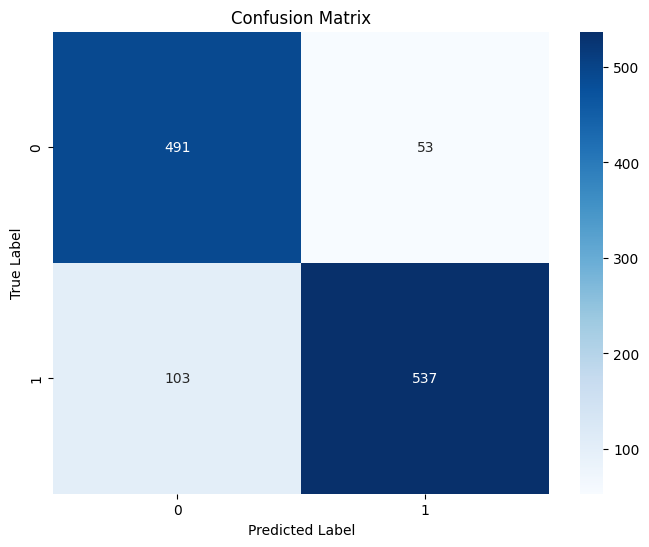

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()